**Prediction**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(224)

In [ ]:
# read json for dictionary mapping
# open from json file
with open('gdrive/My Drive/MemeGenerator/dataset_final_m2/char2idx.json', 'r', encoding = 'UTF-8') as json_file:
    char2idx = json.load(json_file)

# open from json file
with open('gdrive/My Drive/MemeGenerator/dataset_final_m2/img2idx.json', 'r', encoding = 'UTF-8') as json_file:
    img2idx = json.load(json_file)

idx2char = {value:key for key, value in char2idx.items()}
idx2img = {value:key for key, value in img2idx.items()}

In [ ]:
def get_available_devices():
    """Get IDs of all available GPUs.

    Returns:
        device (torch.device): Main device (GPU 0 or CPU).
        gpu_ids (list): List of IDs of all GPUs that are available.
    """
    gpu_ids = []
    if torch.cuda.is_available():
        gpu_ids += [gpu_id for gpu_id in range(torch.cuda.device_count())]
        device = torch.device(f'cuda:{gpu_ids[0]}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    return device, gpu_ids

In [ ]:
#### USED ONLY IF WE LOAD .pth file from save_state_dict()
def load_model(model, checkpoint_path, gpu_ids, return_step=True):
    """Load model parameters from disk.

    Args:
        model (torch.nn.DataParallel): Load parameters into this model.
        checkpoint_path (str): Path to checkpoint to load.
        gpu_ids (list): GPU IDs for DataParallel.
        return_step (bool): Also return the step at which checkpoint was saved.

    Returns:
        model (torch.nn.DataParallel): Model loaded from checkpoint.
        step (int): Step at which checkpoint was saved. Only if `return_step`.
    """
    device = "cuda:" + gpu_ids[0] if gpu_ids else 'cpu' 
    ckpt_dict = torch.load(checkpoint_path, map_location=device)

    # Build model, load parameters
    model.load_state_dict(ckpt_dict['model_state'])

    if return_step:
        step = ckpt_dict['step']
        return model, step

    return model

In [ ]:
class MemeGeneratorLSTM(nn.Module):
    def __init__(self):
        super(MemeGeneratorLSTM, self).__init__()
        self.embedding_dim = 128
        self.img_embedding = 32
        self.seqlen = 1
        self.num_classes = len(char2idx)

        self.lstm_hidden_size = 1024
        self.lstm_layer_size = 1
        self.lstm_num_directions = 1
        
        # Embedding Layer for Images
        self.embedding_img = nn.Embedding(len(img2idx), self.img_embedding)
        # Embedding Layer for character embeddings
        self.embedding_layer = nn.Embedding(len(char2idx), self.embedding_dim, padding_idx = char2idx['<pad>'])
        
        # project to embedding dim
        self.project_down = nn.Linear(self.img_embedding + self.embedding_dim, self.embedding_dim)

        # LSTM layer
        self.lstm_layer = nn.LSTM(input_size = self.embedding_dim, hidden_size = self.lstm_hidden_size, num_layers=self.lstm_layer_size, bidirectional=False, batch_first = True)
        # fc layer
        self.fc = nn.Linear(self.lstm_hidden_size, self.num_classes) 


    def forward(self, input_img, x, prev_state_h, prev_state_c):
        # input_img (batch_size)
        # x is the decoder input (batch_size, 1) where 1 is seqlen
        # prev_state_h (num_layers_dec * num_directions_dec, batch_size, hidden_size_dec)
        # prev_state_c (num_layers_dec * num_directions_dec, batch_size, hidden_size_dec)
        batch_size = x.size()[0]

        # input_img (batch_size, 1)
        input_img = torch.unsqueeze(input_img, dim=1)
        
        # repeat for replication (batch_size, 1)
        input_img = input_img.repeat(1,1)

        # image embeddings (batch_size, 1, img_embedding_dim)
        img_out = self.embedding_img(input_img)

        # embedding shape (batch_size, 1, embedding_dim) where 1 is seqlen
        text_out = self.embedding_layer(x)

        # concatenate between image and caption embeddings
        # (batch_size, 1, text_emb + img_emb) where 1 is seqlen
        cat = torch.cat((img_out, text_out), dim=2)

        # project down to (batch_size, 1, 128) where 1 is seqlen
        embedding_out = self.project_down(cat)

        # apply LSTM layer
        # HERE IN THE DECODER WE PASS IN SEQ_LEN = 1 to force feed decoder
        # input = batchsize x seq_len x input_size -> Here input_size = 128
        # lstm_out = (batch, seq_len, num_directions * hidden_size)
        # hn = hidden at t=seq_len  (numdirection x num_layers, batchsize, hidden_size)
        # cn = cell at t=seq_len (numdirection x num_layers, batchsize, hidden_size)
        lstm_out, (hn, cn) = self.lstm_layer(embedding_out, (prev_state_h, prev_state_c))

        # output shape before squeeze == (batch_size, 1, hidden_size)
        # output shape after squeeze == (batch_size, hidden_size)
        output = torch.squeeze(lstm_out, dim = 1)
        
        # output shape == (batch_size, vocab)
        out = self.fc(output)
        return out, hn, cn #, attention_weights


    def init_state(self, batch_size):
        # first one is layer size * num_directions
        return (torch.zeros(1, batch_size, self.lstm_hidden_size),
                torch.zeros(1, batch_size, self.lstm_hidden_size))

In [ ]:
class MemeGeneratorM2(nn.Module):
    def __init__(self):
        super(MemeGeneratorM2, self).__init__()
        self.memegeneratorlstm = MemeGeneratorLSTM()

    def forward(self, input_img, x, label, device, prediction_mode = False):
        # input_img (batch_size)
        # x is the lstm input (batch_size, 199) where 199 is seqlen
        # label is the label (batch_size, 199) where 199 is seqlen
        # device = "cpu"/"cuda:0"
        # prediction_mode = True/False

        batch_size = input_img.size()[0]

        # LSTM hidden state initialization
        prev_state_h, prev_state_c = self.memegeneratorlstm.init_state(batch_size)
        prev_state_h = prev_state_h.to(device)
        prev_state_c = prev_state_c.to(device)

        # store predictions and outputs
        predictions_arr = []
        output_tensor = torch.zeros((batch_size, 1, len(char2idx)))
        output_tensor = output_tensor.to(device)

        lstm_input = torch.unsqueeze(x[:,0], dim = 1)

        # for prediction only
        first_nonzero = (x == 0).nonzero(as_tuple=False)[0][1].item()

        # Teacher forcing - feeding the target as the next input
        for t in range(0, x.size()[1]): # iterate until len of sequence
             # prediction size (batchsize, num_vocab)
             predictions, prev_state_h, prev_state_c = self.memegeneratorlstm(input_img, lstm_input, prev_state_h, prev_state_c)

             # store lstm_output_tensor
             output_tensor = torch.cat([output_tensor, torch.unsqueeze(predictions, dim=1)], dim = 1)            
             # get one prediction
             one_prediction = torch.max(predictions, dim = 1).indices
             # save the prediction in list
             predictions_arr.append(one_prediction.detach().cpu().numpy())

             if prediction_mode == False:
                 # using teacher forcing
                 lstm_input = torch.unsqueeze(label[:, t], dim = 1)
             else:
                 # only for batchsize = 1
                 # use teacher forcing for initial starter string
                 if t < first_nonzero - 1:
                    lstm_input = torch.zeros((1, 1)).long()
                    lstm_input[0] = x[0][t+1]
                 else:
                    # use prediction as previous output previous input
                    one_prediction = torch.unsqueeze(one_prediction, dim = 1)
                    lstm_input = one_prediction
        
        # remove the original zeros for output_tensor
        # output_tensor shape (batch_size, seqlen, numclasses)
        # predictions_arr shape (seqlen, batch_size)
        output_tensor = output_tensor[:,1:,:]
        predictions_arr = np.array(predictions_arr)
        predictions_arr = np.transpose(predictions_arr)

        return output_tensor, predictions_arr

In [ ]:
def setup_model():
    # load model
    device, gpu_ids = get_available_devices()

    # load from final model
    # model = torch.jit.load("gdrive/My Drive/Yelp_Sentiment_Analysis/best-model-180000.pth")

    # load from state_dict
    model = load_model(MemeGeneratorM2(), 'gdrive/My Drive/MemeGenerator/save/train/baseline-03/step_270150.pth.tar', gpu_ids, return_step=False)

    model = model.to(device)
    model.eval()

    return model, device

**Decoding Algorithm**
- Greedy
  - Take best character at every time step and proceed
- Sampling
  - Randomly sample based on the probabilities at each time step 
- Beam Search
  - at each time step take k best output
  - Algorithm:
    - First generate k predictions with scores
    - Take each prediction and generate k more predictions at each time step from the previous output until we reach k end candidates. Score will be current score P(Y|X) * prev score P(X) = P(X,Y)
    - Iterate until we reach k end candidates
    - Take output (with end token) that has highest score. 

In [ ]:
def do_prediction(device, model, img_num, prediction_mode, beam_width = 3, maxcharpred = 250, test_string = ""):
    # device = device to predict on "cpu" or "cuda:0" for GPU
    # model = character model
    # img_num = encoded image number (0-98)
    # prediction_mode = "greedy", "sampling", "beam"
    # beam_width = parameter of beam search
    # maxcharpred = maximum character length of predictions
    # test_string = starter string for meme

    # Opening Image
    img = plt.imread('gdrive/My Drive/MemeGenerator/img/' + idx2img[img_num] + '.jpg')
    plt.imshow(img)
    
    ### Method to preprocess input for padding
    def preprocess_input(test_string):
        # convert string to number array
        test_string_proc = [char2idx["<start>"]]
        # add any test string
        for char in test_string:
            test_string_proc.append(char2idx[char])
        # add the prepadding
        currlen = len(test_string_proc)
        rem = 199 - currlen  #199 here because length of sequence originally was 199 for input
        test_string_proc.extend([0] * rem)
        return test_string_proc

    # apply method
    # test_string_proc (list of length number of input string)
    test_string_proc = preprocess_input(test_string)

    # keep text generated
    text_generated = [char2idx["<start>"]]
    # add any other from test string
    for elem in test_string:
        text_generated.append(char2idx[elem])

    # Starter string
    input_eval = torch.tensor(test_string_proc).to(device)
    
    # create input image
    # input_img size ([1])
    input_img = torch.zeros(1).long() 
    input_img[0] = img_num # Pick Images
    input_img = input_img.to(device)

    # just for beam search scores
    beam_table = pd.DataFrame()
    beam_candidates = []

    if prediction_mode == "greedy" or prediction_mode == "sampling":
        # predict from inputs
        # predictions size (batch_size, 199) where 199 is seqlen
        input_eval = input_eval.unsqueeze(0)
        predictions, _ = model(input_img, input_eval, None, device, prediction_mode = True)
        predictions = torch.squeeze(predictions, dim = 0)

        # apply softmax to make probabilities
        softmax_layer = nn.Softmax(dim=1)
        predictions = softmax_layer(predictions)

        # Greedy mode 
        if prediction_mode == "greedy":
            best_char = torch.max(predictions, dim=1).indices
            best_char = best_char.detach().cpu().numpy()
            best_char = list(best_char)
            # cut off until <end> token
            if char2idx["<end>"] in best_char:
                endidx = best_char.index(char2idx["<end>"])
                best_char = best_char[:endidx + 1]
            text_generated.extend(best_char)

        # Sampling mode (based on the probabilities generated)
        elif prediction_mode == "sampling":
            # convert to numpy
            predictions = predictions.detach().cpu().numpy()
            # iterate thorugh the sequence length
            for i in range(predictions.shape[0]):
                # randomly choose based on probability
                predicted_id = np.random.choice(len(char2idx), size = 1, replace = False, p = predictions[i])
                # save generated chars
                text_generated.append(predicted_id[0])
                # break the loop if <end> token is generated
                if char2idx["<end>"] == predicted_id[0]:
                    break

        final = ''
        final += ''.join([idx2char[elem] for elem in text_generated])
        print(final)
        return None

    elif prediction_mode == "beam":
        # Beam Search Prediction
        def predict_beam_search(input_seq, pos):
            # convert input to tensors
            input_seq = torch.tensor(input_seq).to(device)
            input_seq = input_seq.unsqueeze(0)

            # predict from inputs
            predictions, _ = model(input_img, input_seq, None, device, prediction_mode = True)

            # apply softmax to make probabilities
            softmax_layer = nn.Softmax(dim=1)
            predictions = softmax_layer(predictions)
            predictions = torch.squeeze(predictions, dim=0)

            # convert to numpy shape (199, 72)
            predictions = predictions.detach().cpu().numpy()
            predictions = predictions[first_nonzero]
            #print(predictions[first_nonzero])
            # Take top k scores
            indexes = sorted(range(len(predictions)), key=lambda i: predictions[i])[-beam_width:]
            scores = [predictions[elem] for elem in indexes]
            return indexes, scores

        #### First Iteration of Beam Search
        first_nonzero = len(text_generated) + 1
        indexes, scores = predict_beam_search(input_eval, first_nonzero)
        # add to df for bookeeping
        col_a = []
        col_b= []      
        for idx, elem in enumerate(indexes):
            beam_temp = text_generated.copy()
            beam_temp.append(elem)
            col_a.append(beam_temp)
            col_b.append(scores[idx])
            beam_candidates.append(beam_temp)

        temp_df = pd.DataFrame()
        temp_df['candidates'] = col_a
        temp_df['score'] = col_b
        beam_table = beam_table.append(temp_df)
        #######

        # Method for bookeeping
        def bookkeep(indexes, scores, curr):
          col_a = []
          col_b= []      
          for idx, elem in enumerate(indexes):
              beam_temp = curr.copy()
              beam_temp.append(elem)
              col_a.append(beam_temp)
              col_b.append(scores[idx])

          temp_df = pd.DataFrame()
          temp_df['candidates'] = col_a
          temp_df['score'] = col_b
          return temp_df
      
        def pad_sequences(curr_seq):
          currlen = len(curr_seq)
          rem = 199 - currlen
          curr_seq.extend([0] * rem)
          return curr_seq


        count_done = 0
        first_nonzero = first_nonzero + 1 # need to keep increasing length
        ### Beam Search
        while count_done != beam_width:
            sec_df = pd.DataFrame()
            while len(beam_candidates) != 0:
                curr = beam_candidates.pop()
                curr_pad = pad_sequences(curr.copy())
                indexes, scores = predict_beam_search(curr_pad, first_nonzero)
                temp_df = bookkeep(indexes, scores, curr)
                sec_df = sec_df.append(temp_df, ignore_index=True)

            # take top k in pandas dataframe 
            sec_df = sec_df.sort_values(by=['score'], ascending = False).reset_index(drop = True)
            sec_df = sec_df.loc[0:(beam_width - count_done - 1),:]


            # Multiply Scores and place candidates in beam candidates array
            for i in range((beam_width-count_done)):
                curr_score = sec_df.loc[i, 'score']
                curr_arr = sec_df.loc[i, 'candidates']
                # get past score and multiply since it is conditional probability
                m = beam_table['candidates'].apply(lambda x: x == curr_arr[:-1])
                prev_score = beam_table.loc[m, :].loc[:, 'score'].values
                sec_df.loc[i, 'score'] = curr_score * prev_score[0]
              
                # last elem check -> If <end> add to count_done to reduce candidates
                if curr_arr[-1] == char2idx["<end>"]:
                    count_done += 1
                elif curr_arr[-1] == char2idx["<start>"]:
                    count_done += 1
                else:
                    # add to candidates
                    beam_candidates.append(curr_arr)
     
            # append all candidates to master table
            beam_table = beam_table.append(sec_df, ignore_index = True)

            # increase position for beam search
            first_nonzero += 1

        # filter only those with end token
        def has_endtoken(x):
            if char2idx["<end>"] in x:
                return True
            else:
                return False
        beam_table['contains_end'] = beam_table['candidates'].apply(lambda x: has_endtoken(x))
        beam_table = beam_table[beam_table['contains_end'] == True]

        # sort by scores
        beam_table = beam_table.sort_values(by=['score'], ascending = False)
        
        final = '' 
        final += ''.join([idx2char[elem] for elem in beam_table.iloc[0, 0] ])
        print(final)
        return None

In [ ]:
# setup model
model, device = setup_model()

<start>i aas sonng to we dbflld meme<sep>afjin't know what aoeylill ns o.meme<end>


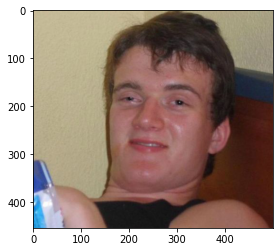

In [ ]:
test_string = ""
do_prediction(device, model, img_num = 0, prediction_mode = "sampling", test_string = "")

In [ ]:
idx2img

{0: '10-Guy',
 1: 'Aaaaand-Its-Gone',
 2: 'Aint-Nobody-Got-Time-For-That',
 3: 'Am-I-The-Only-One-Around-Here',
 4: 'American-Chopper-Argument',
 5: 'Ancient-Aliens',
 6: 'And-everybody-loses-their-minds',
 7: 'Archer',
 8: 'Awkward-Moment-Sealion',
 9: 'Back-In-My-Day',
 10: 'Bad-Luck-Brian',
 11: 'Bad-Pun-Dog',
 12: 'Batman-Slapping-Robin',
 13: 'Be-Like-Bill',
 14: 'Bernie-I-Am-Once-Again-Asking-For-Your-Support',
 15: 'Black-Girl-Wat',
 16: 'Blank-Nut-Button',
 17: 'Boardroom-Meeting-Suggestion',
 18: 'Brace-Yourselves-X-is-Coming',
 19: 'But-Thats-None-Of-My-Business',
 20: 'Captain-Picard-Facepalm',
 21: 'Change-My-Mind',
 22: 'Confession-Bear',
 23: 'Conspiracy-Keanu',
 24: 'Creepy-Condescending-Wonka',
 25: 'Disaster-Girl',
 26: 'Doge',
 27: 'Dont-You-Squidward',
 28: 'Dr-Evil-Laser',
 29: 'Drake-Hotline-Bling',
 30: 'Epic-Handshake',
 31: 'Evil-Kermit',
 32: 'Evil-Toddler',
 33: 'Expanding-Brain',
 34: 'Face-You-Make-Robert-Downey-Jr',
 35: 'Finding-Neverland',
 36: 'First-Wor

In [ ]:
char2idx["<end>"]

70